# INTRODUCTION

We try to predict the genetic disorder of patients based on multiple features

# IMPORT & SETUP

In [13]:
from keras import models, layers, optimizers
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [3]:
file_path = 'dataset/train.csv'
data = pd.read_csv(file_path)

In [4]:
features_used = ['Inherited from father', 'Maternal gene', 'Paternal gene', 'Genes in mother\'s side', 'Symptom 1',
                 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']
targets = ['Genetic Disorder', 'Disorder Subclass']

dataset = data.loc[:, features_used + targets].dropna(subset=['Genetic Disorder', 'Disorder Subclass'], how='all')
# Fill missing values in 'Genetic Disorder' based on 'Disorder Subclass'
subclass_to_disorder = {
    'Leber\'s hereditary optic neuropathy': 'Mitochondrial genetic inheritance disorders',
    'Leigh syndrome': 'Mitochondrial genetic inheritance disorders',
    'Mitochondrial myopathy': 'Mitochondrial genetic inheritance disorders',
    'Alzheimer\'s': 'Multifactorial genetic inheritance disorders',
    'Cancer': 'Multifactorial genetic inheritance disorders',
    'Diabetes': 'Multifactorial genetic inheritance disorders',
    'Cystic fibrosis': 'Single-gene inheritance diseases',
    'Hemochromatosis': 'Single-gene inheritance diseases',
    'Tay-Sachs': 'Single-gene inheritance diseases',
}

dataset['Genetic Disorder'] = dataset.apply(
    lambda row: subclass_to_disorder[row['Disorder Subclass']]
    if pd.isna(row['Genetic Disorder']) else row['Genetic Disorder'],
    axis=1
)

dataset = dataset.dropna(subset=['Disorder Subclass'], how='all')

# CATEGORIAL BINARY
dataset["Genes in mother's side"] = dataset["Genes in mother's side"].replace({'Yes': 1.0, 'No': 0.0})
dataset['Inherited from father'] = dataset['Inherited from father'].replace({'No': 0.0, 'Yes': 1.0})
dataset['Maternal gene'] = dataset['Maternal gene'].replace({'No': 0.0, 'Yes': 1.0})
dataset["Paternal gene"] = dataset["Paternal gene"].replace({'Yes': 1.0, 'No': 0.0})

# dataset = dataset.dropna(subset=['Symptom 4', 'Symptom 5'])
#-------------------------------------------------------%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--------------------------------#
genetic_disorder_mapping = {
    'Mitochondrial genetic inheritance disorders': 1,
    'Multifactorial genetic inheritance disorders': 0,
    'Single-gene inheritance diseases': 2,
}
dataset['Genetic Disorder'] = dataset['Genetic Disorder'].map(genetic_disorder_mapping)

disorder_subclass_mapping = {
    "Leber's hereditary optic neuropathy": 0,
    'Cystic fibrosis': 1,
    'Diabetes': 2,
    'Leigh syndrome': 3,
    'Tay-Sachs': 4,
    'Mitochondrial myopathy': 5,
    'Hemochromatosis': 6,
    "Alzheimer's": 7,
    'Cancer': 8,
}

dataset['Disorder Subclass'] = dataset['Disorder Subclass'].map(disorder_subclass_mapping)
heat_data = dataset.copy().dropna()

<AxesSubplot: >

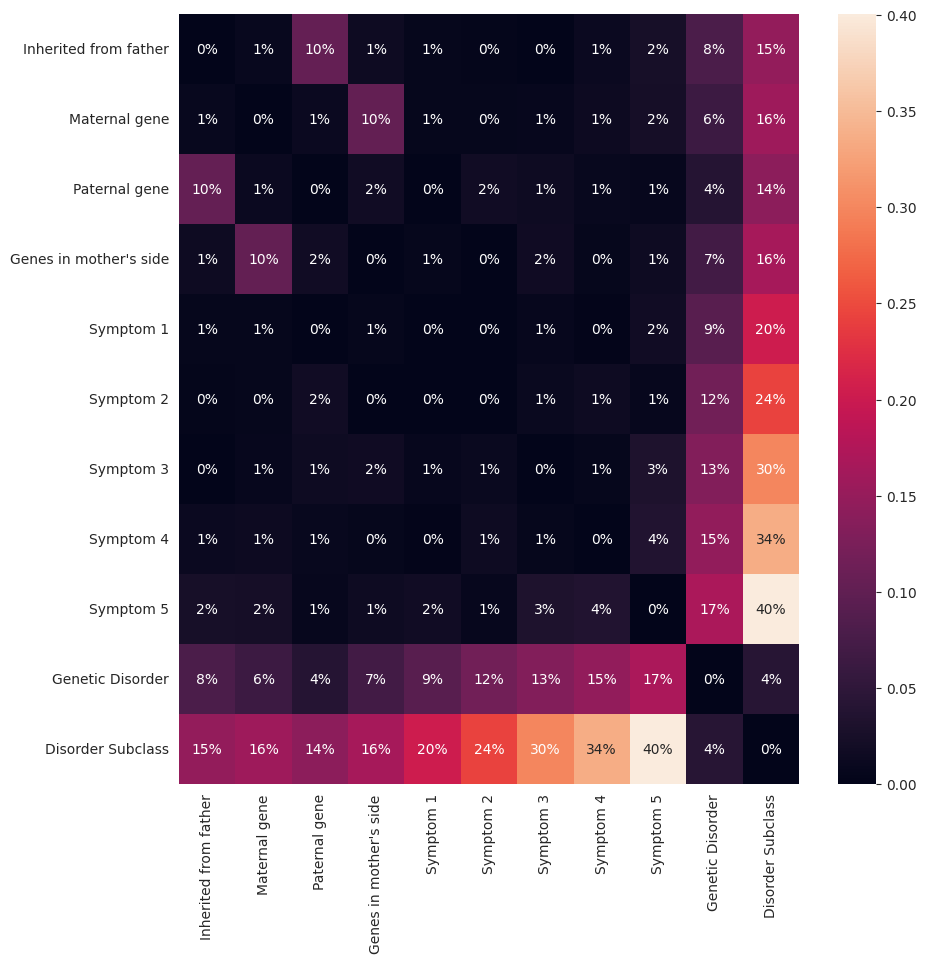

In [5]:
corr = heat_data.corr().applymap(lambda x: 0 if x > 0.99 else abs(x))
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".0%")

In [6]:
robust_scaler = RobustScaler()

X_train, X_test, Y_train, Y_test = train_test_split(robust_scaler.fit_transform(heat_data.loc[:, features_used]),
                                                    heat_data.loc[:, 'Genetic Disorder'],
                                                    test_size=0.2, random_state=43)

In [18]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
lp_models, predictions = clf.fit(X_train, X_test, Y_train, Y_test)
lp_models

100%|██████████| 29/29 [00:11<00:00,  2.55it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 9328, number of used features: 9
[LightGBM] [Info] Start training from score -2.248134
[LightGBM] [Info] Start training from score -0.669627
[LightGBM] [Info] Start training from score -0.961015


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.47,0.58,None,0.47,0.04
LGBMClassifier,0.65,0.58,None,0.65,0.12
SVC,0.65,0.58,None,0.64,2.33
ExtraTreeClassifier,0.65,0.57,None,0.64,0.02
ExtraTreesClassifier,0.65,0.57,None,0.64,0.36
LabelPropagation,0.65,0.57,None,0.64,2.08
DecisionTreeClassifier,0.65,0.57,None,0.64,0.02
LabelSpreading,0.64,0.57,None,0.64,3.92
RandomForestClassifier,0.64,0.57,None,0.64,0.32
